# Project 2: Data Representations and Clustering

## Group Members
- Shaira Alam

- Vani Agrawal 

- Dhakshina Ilango

## Package Installation

In [1]:
! pip install numpy
! pip install scikit-learn
! pip install umap-learn
! pip install hdbscan

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import TruncatedSVD, NMF
import numpy as np
import plotmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
import numpy as np 
from plotmat import plot_mat
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
import hdbscan

# Part 1 - Clustering on Text Data

## Question 1

### 1.1 Report the dimensions of the TF-IDF matrix you obtain.

In [3]:

# Categories for Class 1 and 2
comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

# Loads the dataset
newsgroups_data = fetch_20newsgroups(subset='all', categories=comp_categories+rec_categories, shuffle=True, remove=('headers', 'footers'), random_state=42)

In [4]:
# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(min_df=3, stop_words='english')
X_train_tfidf = tfidf_vect.fit_transform(newsgroups_data.data)

# Dimensions of the TD-IDF matrix
tfidf_dims = X_train_tfidf.shape

print("Dimensions of the TD-IDF matrix: ",tfidf_dims)

Dimensions of the TD-IDF matrix:  (7882, 23522)


## Question 2

### 2.1 Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix.

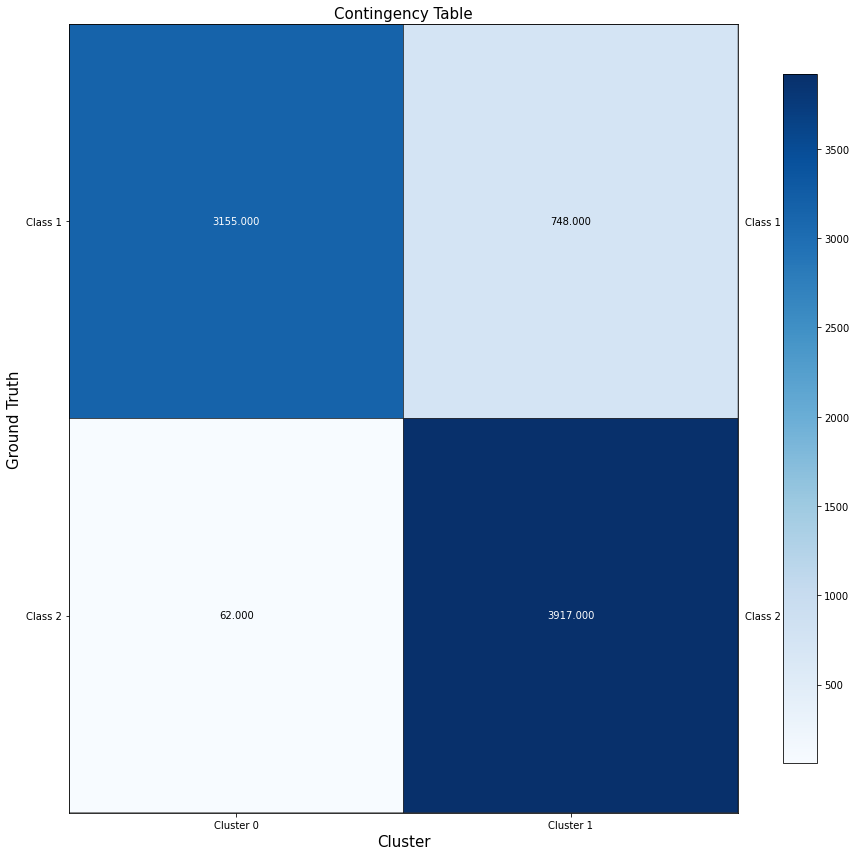

In [5]:
# K-means clustering with k = 2 using the TF-IDF data
k = 2
km = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=30)
clusters = km.fit_predict(X_train_tfidf)

# Ground truth labels
ground_truth = [int(i/4) for i in newsgroups_data.target]

mat = contingency_matrix(ground_truth, clusters)

# Visualizing the matrix using plotmat.py
xlabels = ['Cluster 0', 'Cluster 1']
ylabels = ['Class 1', 'Class 2']
plotmat.plot_mat(mat, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(12,12), title="Contingency Table")


### 2.2 Does the contingency matrix have to be square-shaped?

No, the contingency matrix does not have to be square shaped since the contingency matrix is a matrix where the rows represent the ground truth labels and the columns represent the predicted cluster labels, so therefore the contingency matrix can be rectangular shaped as well. However, in this scenario, since we only had 2 clusters and 2 ground truth labels, the contingency matrix was square-shaped.

## Question 3

### 3.1 Report the 5 clustering measures explained in the introduction for K-means clustering.

### 1. Homogeneity 
- is a measure of how “pure” the clusters are. If each cluster contains only data points from a single class, the homogeneity is satisfied.

In [6]:
h_score= homogeneity_score(ground_truth,clusters)
print("Homogeneity Score:", h_score)

Homogeneity Score: 0.568013245785168


### 2. Completeness 
- indicates how much of the data points of a class are assigned to the same cluster.

In [7]:
c_score = completeness_score(ground_truth,clusters)
print("Completeness:", c_score)

Completeness: 0.5822303423168675


### 3. V-measure
- is the harmonic average of homogeneity score and completeness score.

In [8]:
v_score = v_measure_score(ground_truth,clusters)
print("V-measure:", v_score)

V-measure: 0.5750339318643112


### 4. Adjusted Rand Index 
- is similar to accuracy, which computes similarity between the clustering labels and ground truth labels. This method counts all pairs of points that both fall either in the same cluster and the same class or in different clusters and different classes.

In [9]:
adj_ri = adjusted_rand_score(ground_truth,clusters)
print("Adjusted Rand Index:", adj_ri)

Adjusted Rand Index: 0.631133674855338


### 5. Adjusted Mutual Information Score 
- measures the mutual information between the cluster label distribution and the ground truth label distributions.

In [10]:
adj_mi = adjusted_mutual_info_score(ground_truth,clusters)
print("Adjusted Mutual Information Score:", adj_mi)

Adjusted Mutual Information Score: 0.5749945448304503


## Question 4

### 4.1 Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.

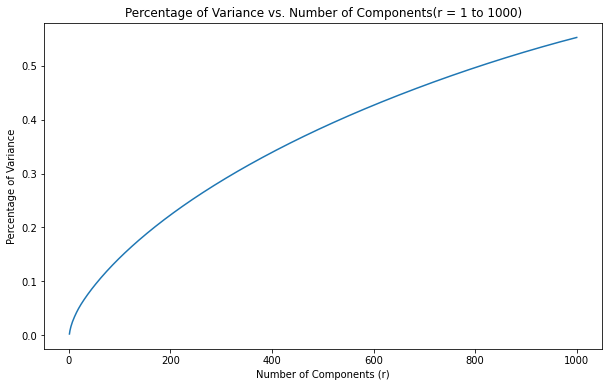

In [11]:
# Truncated SVD
r = 1000
svd = TruncatedSVD(n_components=r, random_state=0)
svd.fit_transform(X_train_tfidf)

# Cumulative explained variance ratio for each component
explained_variance = svd.explained_variance_ratio_.cumsum()

# R components
X_vals = np.array(range(1, r+1))

# Plot of the percentage of variance vs number of components
plt.figure(figsize=(10,6))
plt.plot(X_vals, explained_variance)
plt.title("Percentage of Variance vs. Number of Components(r = 1 to 1000)")
plt.xlabel("Number of Components (r)")
plt.ylabel("Percentage of Variance")
plt.show()

## Question 5

### 5.1 Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1 − 10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD and NMF.

In [12]:
r_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Metric scores for SVD
svd_h_score, svd_c_score, svd_v_score, svd_ajd_ri, svd_adj_mi = [], [], [], [], []

# Loops over the r values
for r in r_vals:
    # SVD
    svd = TruncatedSVD(n_components=r, random_state=0)
    X_train_svd = svd.fit_transform(X_train_tfidf)

    # K-Means
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    svd_cluster = km.fit_predict(X_train_svd)

    # Clusters metric scores for SVD
    svd_h_score.append(homogeneity_score(ground_truth, svd_cluster))
    svd_c_score.append(completeness_score(ground_truth, svd_cluster))
    svd_v_score.append(v_measure_score(ground_truth, svd_cluster))
    svd_ajd_ri.append(adjusted_rand_score(ground_truth, svd_cluster))
    svd_adj_mi.append(adjusted_mutual_info_score(ground_truth, svd_cluster))

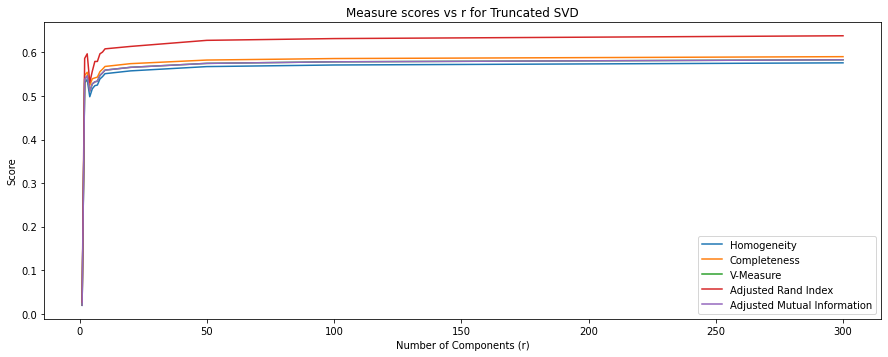

In [13]:
# Truncated SVD Plot
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals, svd_h_score, label='Homogeneity')
plt.plot(r_vals, svd_c_score, label='Completeness')
plt.plot(r_vals, svd_v_score, label='V-Measure')
plt.plot(r_vals, svd_ajd_ri, label='Adjusted Rand Index')
plt.plot(r_vals, svd_adj_mi, label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r for Truncated SVD")
plt.legend()

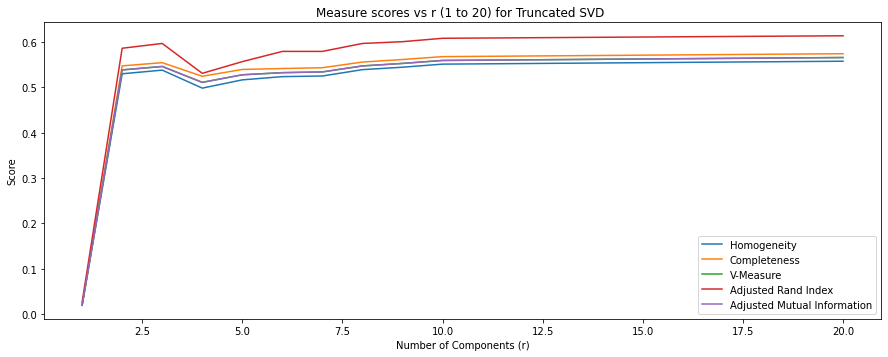

In [14]:
# Zoomed Truncated SVD plot (r = 1 to 20)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals[:11], svd_h_score[:11], label='Homogeneity')
plt.plot(r_vals[:11], svd_c_score[:11], label='Completeness')
plt.plot(r_vals[:11], svd_v_score[:11], label='V-Measure')
plt.plot(r_vals[:11], svd_ajd_ri[:11], label='Adjusted Rand Index')
plt.plot(r_vals[:11], svd_adj_mi[:11], label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r (1 to 20) for Truncated SVD ")
plt.legend()

In [15]:
r_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Metric scores for NMF
nmf_h_score, nmf_c_score, nmf_v_score, nmf_ajd_ri, nmf_adj_mi = [], [], [], [], []

# Loops over the r values
for r in r_vals:
    # NMF
    nmf = NMF(n_components=r, random_state=0, max_iter=2000)
    X_train_nmf = nmf.fit_transform(X_train_tfidf)

    # K-means
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    nmf_cluster = km.fit_predict(X_train_nmf)

    # Clusters metric scores for NMF
    nmf_h_score.append(homogeneity_score(ground_truth, nmf_cluster))
    nmf_c_score.append(completeness_score(ground_truth, nmf_cluster))
    nmf_v_score.append(v_measure_score(ground_truth, nmf_cluster))
    nmf_ajd_ri.append(adjusted_rand_score(ground_truth, nmf_cluster))
    nmf_adj_mi.append(adjusted_mutual_info_score(ground_truth, nmf_cluster))

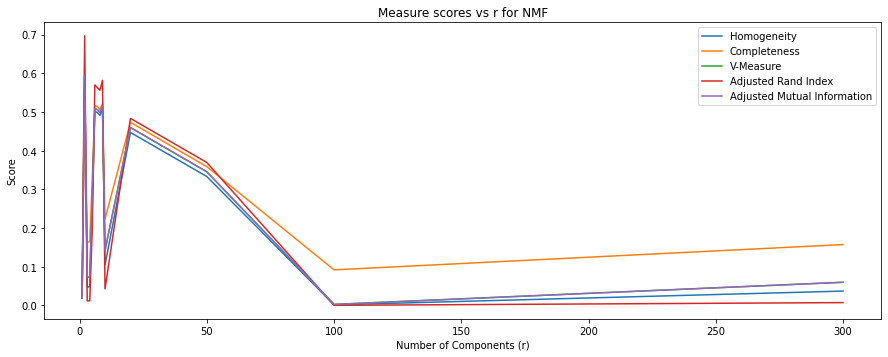

In [16]:
# NMF Plot
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals, nmf_h_score, label='Homogeneity')
plt.plot(r_vals, nmf_c_score, label='Completeness')
plt.plot(r_vals, nmf_v_score, label='V-Measure')
plt.plot(r_vals, nmf_ajd_ri, label='Adjusted Rand Index')
plt.plot(r_vals, nmf_adj_mi, label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r for NMF")
plt.legend()

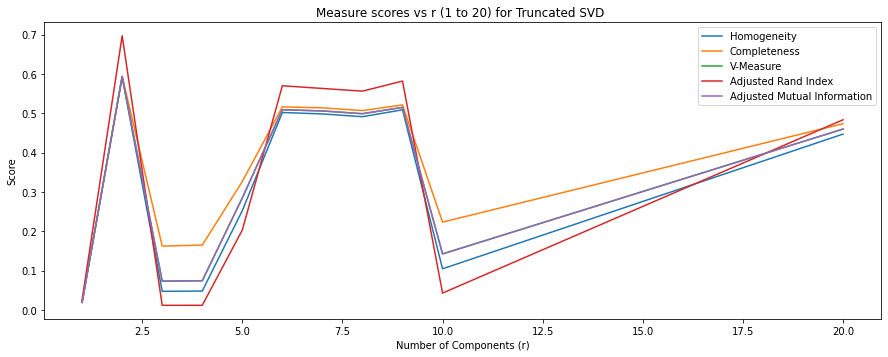

In [17]:
# Zoomed NMF plot (r = 1 to 20)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals[:11], nmf_h_score[:11], label='Homogeneity')
plt.plot(r_vals[:11], nmf_c_score[:11], label='Completeness')
plt.plot(r_vals[:11], nmf_v_score[:11], label='V-Measure')
plt.plot(r_vals[:11], nmf_ajd_ri[:11], label='Adjusted Rand Index')
plt.plot(r_vals[:11], nmf_adj_mi[:11], label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r (1 to 20) for Truncated SVD ")
plt.legend()

### 5.2 Report a good choice of r for SVD and NMF respectively.

According to the graphs, the best rank for SVD is 20 and the best rank for NMF is 2.

## Question 6

### 6.1 How do you explain the non-monotonic behavior of the measures as r increases?

*incomplete*

## Question 7

### 7.1 Are these measures on average better than those computed in Question 3?

*incomplete*

## Question 8

### 8.1 Visualize the clustering results for SVD with your optimal choice of r for K-Means clustering

Text(0.5, 1.0, 'Ground Truth K-Means clustering (SVD)')

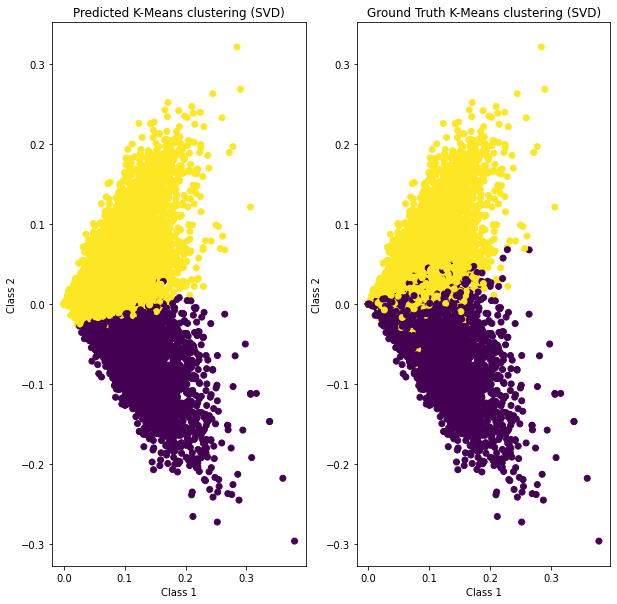

In [18]:
# Optimal choice of r
opt_r_svd = 20

# SVD
svd = TruncatedSVD(n_components=opt_r_svd, random_state=0)
X_train_svd = svd.fit_transform(X_train_tfidf)

# K-Means
km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
svd_cluster = km.fit_predict(X_train_svd)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=svd_cluster, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Predicted K-Means clustering (SVD)')

plt.subplot(122)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=ground_truth, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Ground Truth K-Means clustering (SVD)')

### 8.2 Visualize the clustering results for NMF with your choice of r for K-Means clustering.

Text(0.5, 1.0, 'Ground Truth K-Means clustering (NMF)')

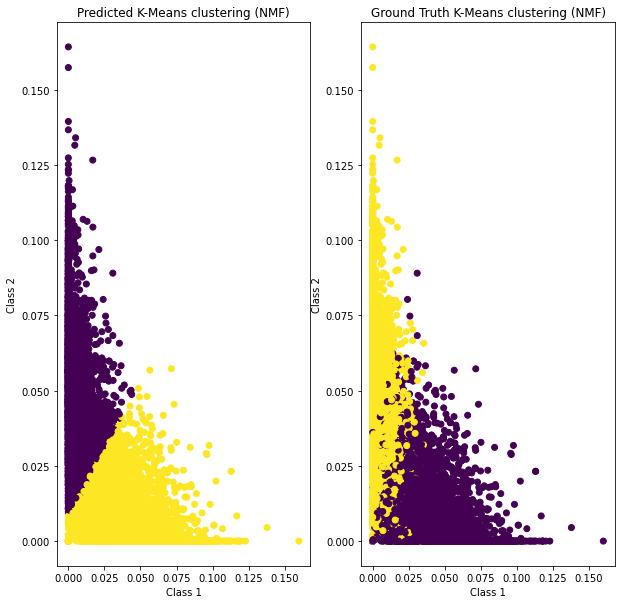

In [19]:
# Optimal choice of r
opt_r_nmf = 2

# NMF
nmf = NMF(n_components=opt_r_nmf, random_state=0, max_iter=2000)
X_train_nmf = nmf.fit_transform(X_train_tfidf)

# K-means
km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
nmf_cluster = km.fit_predict(X_train_nmf)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.scatter(X_train_nmf[:, 0], X_train_nmf[:, 1], c=nmf_cluster, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Predicted K-Means clustering (NMF)')

plt.subplot(122)
plt.scatter(X_train_nmf[:, 0], X_train_nmf[:, 1], c=ground_truth, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Ground Truth K-Means clustering (NMF)')

## Question 9

### 9.1 What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?

#### QUESTION 10: Load documents with the same configuration as in Question 1, but for ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality using BOTH NMF and SVD (specify settings you choose and why), and perform K-Means clustering with k=20 . Visualize the contingency matrix and report the five clustering metrics (DO BOTH NMF AND SVD).

- The dimensions of the TF-IDF matrix is (18846, 45365)
- From Q5 we got optimal value of r as 2 for NMF and 300 for SVD therefore these values of r will be used for NMF and SVD respectively 

In [20]:
# Load the dataset
newsgroups_data20 = fetch_20newsgroups(subset='all', shuffle=True, remove=('headers', 'footers'), random_state=42)

In [21]:
# TF-IDF Vectorizer
tfidf_vect20 = TfidfVectorizer(min_df=3, stop_words='english')
X_train_tfidf20 = tfidf_vect20.fit_transform(newsgroups_data20.data)

print("Dimensions of the TD-IDF matrix: ", X_train_tfidf20.shape)

Dimensions of the TD-IDF matrix:  (18846, 45365)


### NMF

In [22]:
# NMF
nmf20 = NMF(n_components=2, random_state=0, max_iter=2000)
X_train_nmf20 = nmf20.fit_transform(X_train_tfidf20)

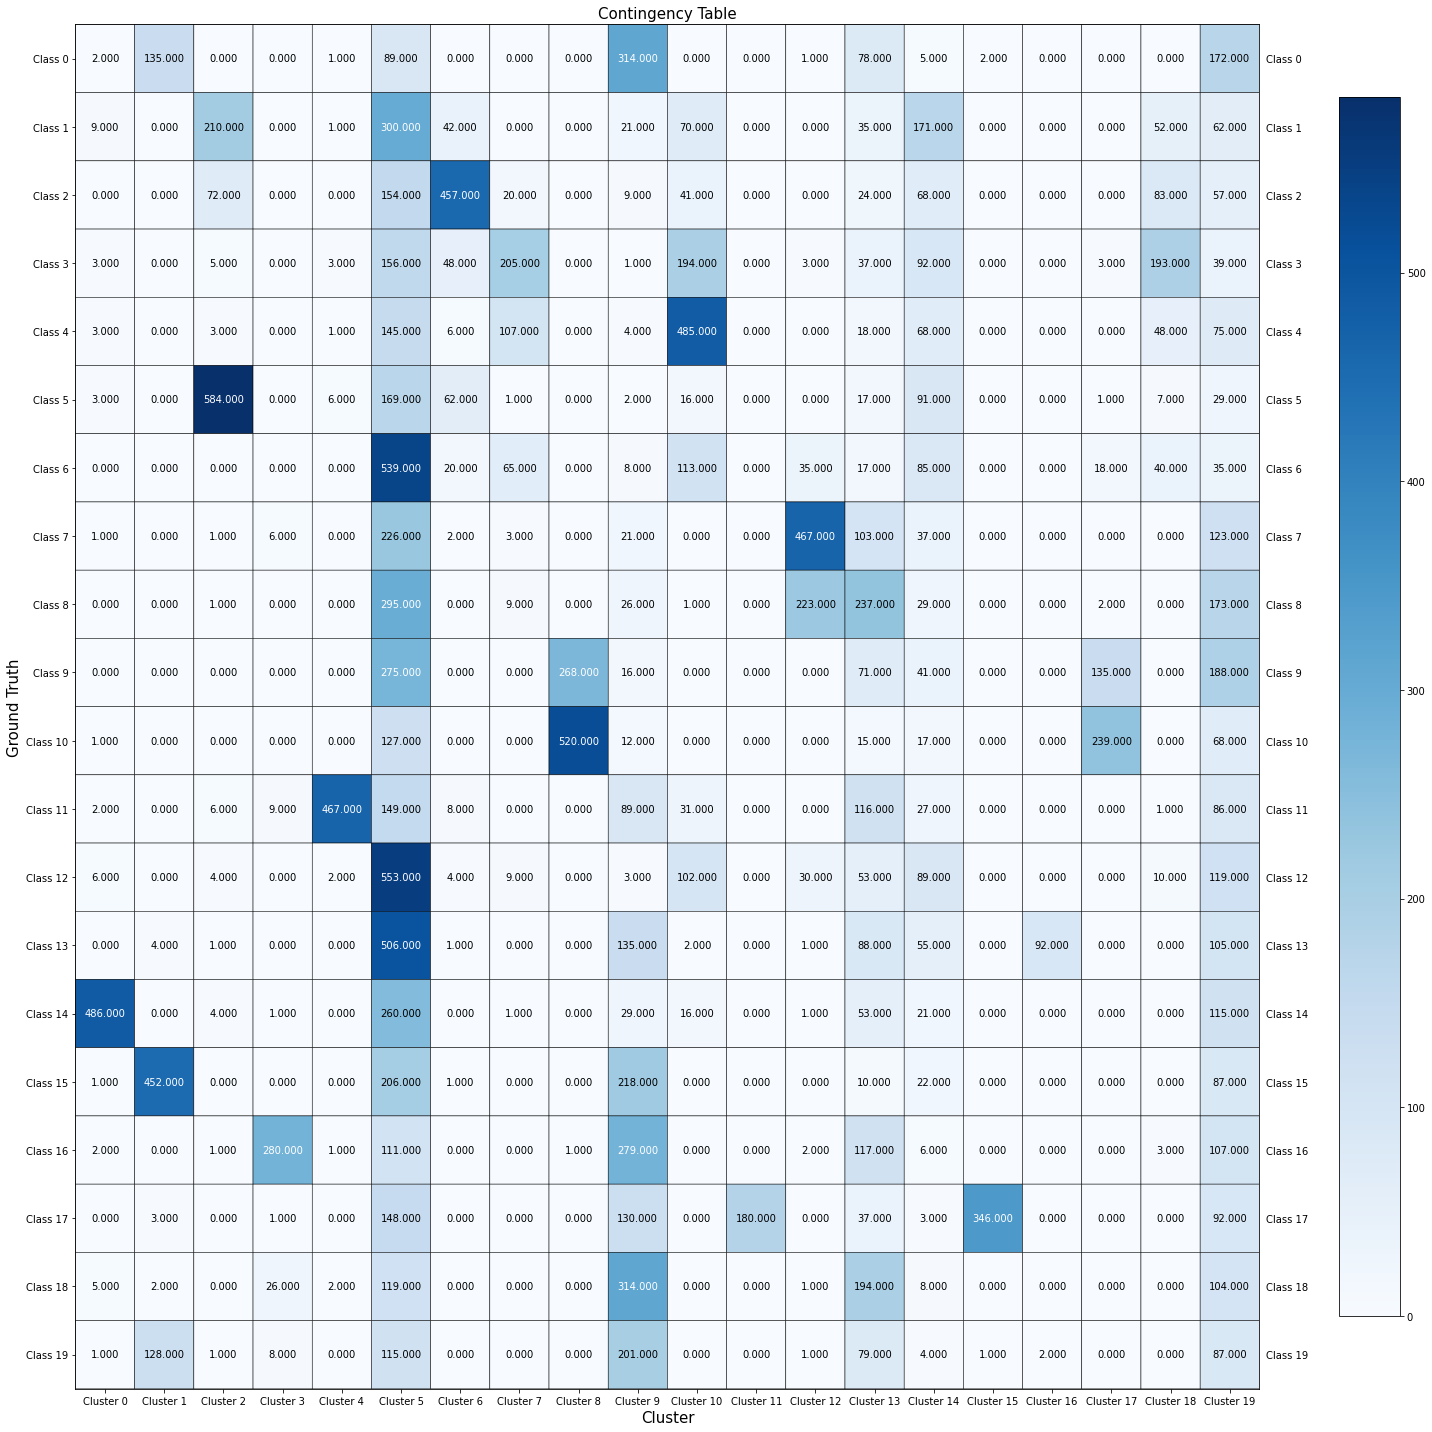

In [23]:

km_nmf20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
clusters_nmf20 = km_nmf20.fit_predict(X_train_tfidf20)

# Ground truth labels
ground_truth = newsgroups_data20.target

mat_nmf20 = contingency_matrix(ground_truth, clusters_nmf20)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,20)]
ylabels = [f'Class {i}'.format(i) for i in range(0,20)]
plotmat.plot_mat(mat_nmf20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

In [24]:
print("Homogeneity Score:", homogeneity_score(ground_truth, clusters_nmf20))
print("Completeness:", completeness_score(ground_truth,clusters_nmf20))
print("V-measure:", v_measure_score(ground_truth,clusters_nmf20))
print("Adjusted RI", adjusted_rand_score(ground_truth, clusters_nmf20))
print("Adjusted MI", adjusted_mutual_info_score(ground_truth, clusters_nmf20))

Homogeneity Score: 0.34790859768456994
Completeness: 0.39677714833898997
V-measure: 0.370739421317011
Adjusted RI 0.12210793219608113
Adjusted MI 0.3685640146343022


### SVD

In [25]:
# SVD
svd20 = TruncatedSVD(n_components=300, random_state=0)
X_train_svd20 = svd20.fit_transform(X_train_tfidf20)

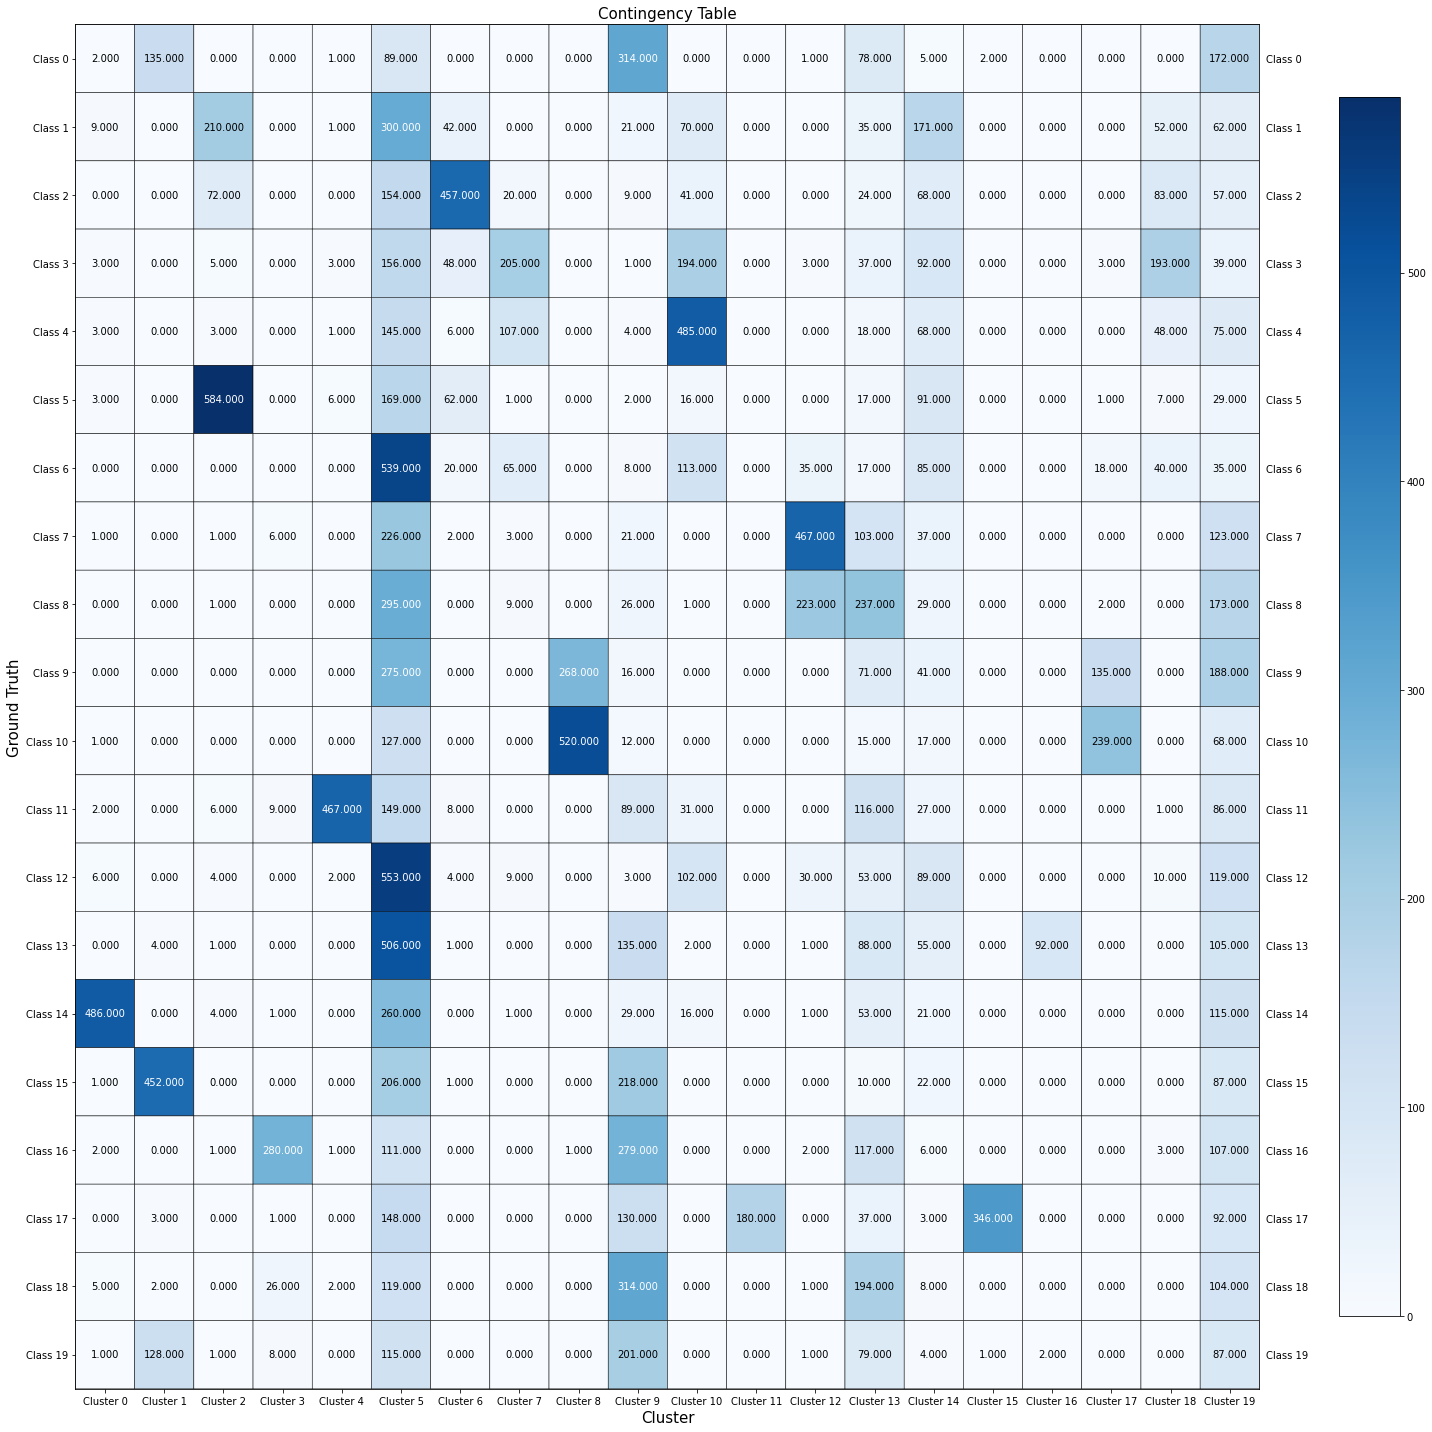

In [26]:
km_svd20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
clusters_svd20 = km_svd20.fit_predict(X_train_tfidf20)

# Ground truth labels
ground_truth = newsgroups_data20.target

mat_svd20 = contingency_matrix(ground_truth, clusters_svd20)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,20)]
ylabels = [f'Class {i}'.format(i) for i in range(0,20)]
plotmat.plot_mat(mat_svd20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

In [27]:
print("Homogeneity Score:", homogeneity_score(ground_truth, clusters_svd20))
print("Completeness:", completeness_score(ground_truth,clusters_svd20))
print("V-measure:", v_measure_score(ground_truth,clusters_svd20))
print("Adjusted RI", adjusted_rand_score(ground_truth, clusters_svd20))
print("Adjusted MI", adjusted_mutual_info_score(ground_truth, clusters_svd20))

Homogeneity Score: 0.34790859768456994
Completeness: 0.39677714833898997
V-measure: 0.370739421317011
Adjusted RI 0.12210793219608113
Adjusted MI 0.3685640146343022


### There is a mismatch between cluster labels and class labels. For example, the cluster #3 may correspond to the class #8. As a result, the high-value entries of the 20 × 20 contingency matrix can be scattered around, making it messy to inspect, even if the clustering result is not bad. One can use scipy.optimize.linear_sum_assignment to identify the best-matching cluster-class pairs, and permute the columns of the contingency matrix accordingly. 

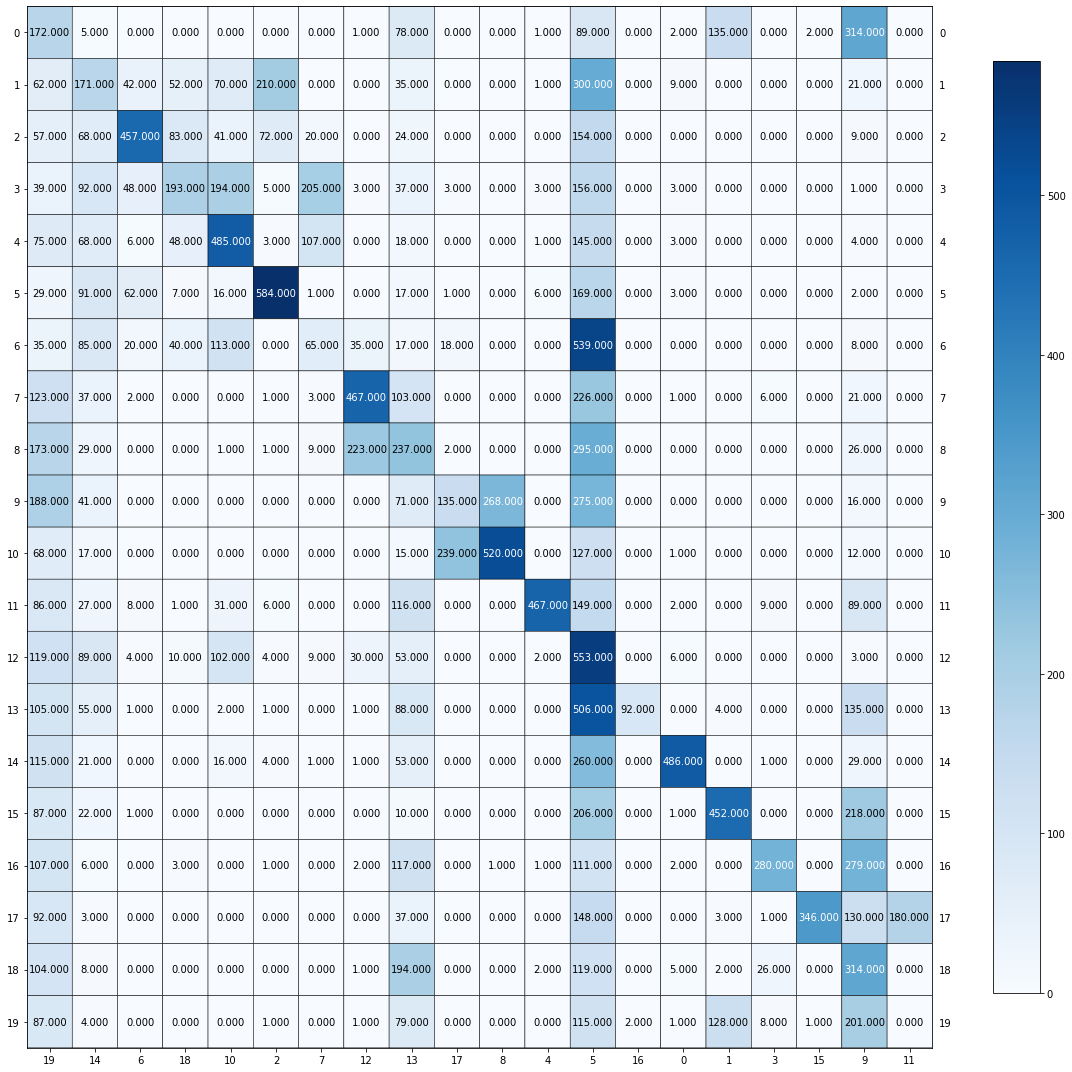

In [28]:
# Contingency Matrix for SVD
cm_svd20 = confusion_matrix(ground_truth, clusters_svd20)
rows, cols = linear_sum_assignment(cm_svd20, maximize = True)
plot_mat(cm_svd20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15))

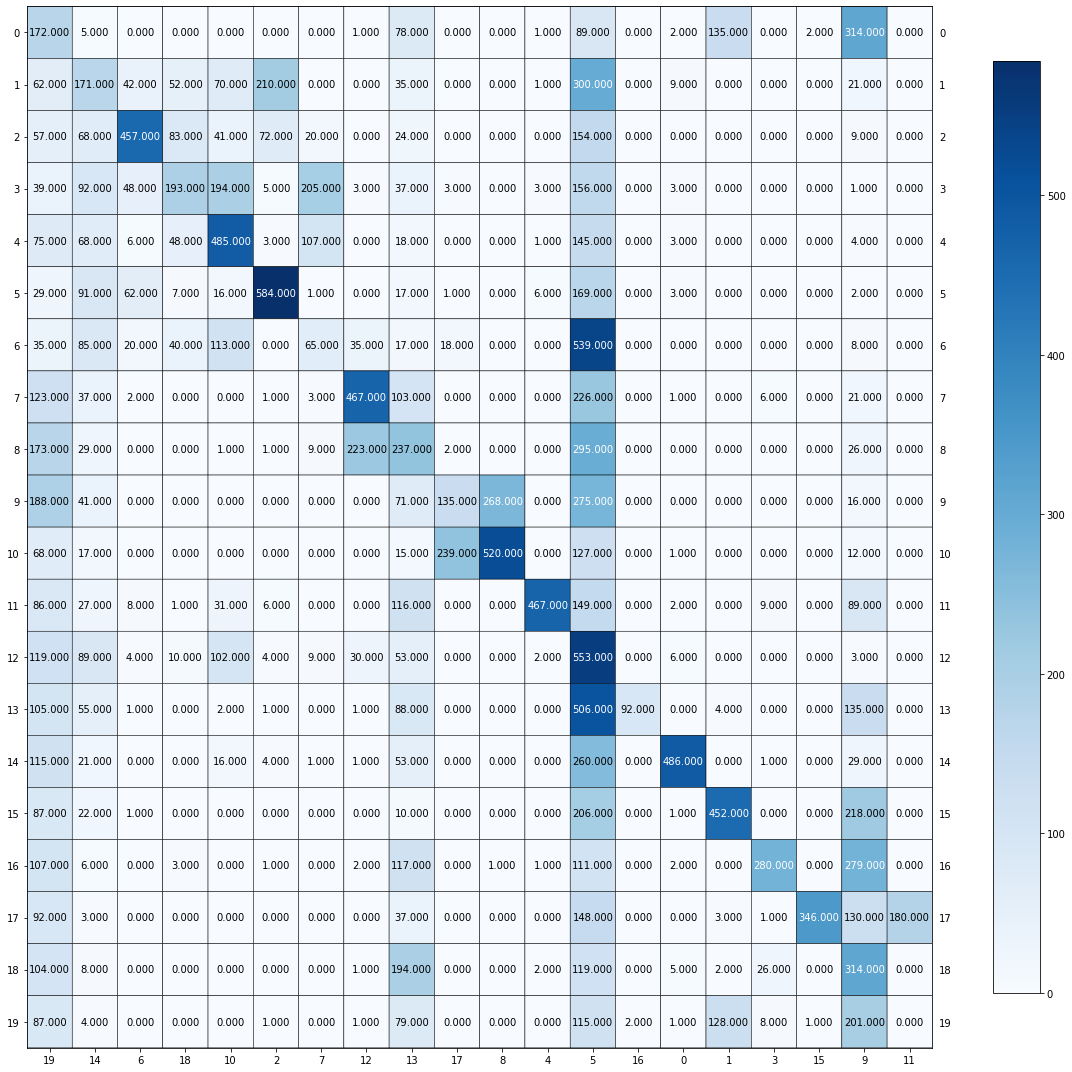

In [29]:
# Contingency Matrix for NMF
cm_nmf20 = confusion_matrix(ground_truth, clusters_nmf20)
rows, cols = linear_sum_assignment(cm_nmf20, maximize = True)
plot_mat(cm_nmf20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15))


### QUESTION 11: Reduce the dimension of your dataset with UMAP. Consider the following settings: n components = [5, 20, 200], metric = ”cosine” vs. ”euclidean”. If ”cosine” metric fails, please look at the FAQ at the end of this spec. Report the permuted contingency matrix and the five clustering evaluation metrics for the different combinations (6 combinations).

In [30]:
eval_scores ={
  'n_components': [],
  'metric': [],
  'h_score': [],
  'c_score': [],
  'v_score': [],
  'adj_rand': [],
  'adj_mutual_info': []
}

In [31]:
def umap_metrics(n_components, metric, title="UMAP"):
  # Dimensionality Reduction using UMAP
  reducer = umap.UMAP(n_components=n_components, metric=metric)
  embedding = reducer.fit_transform(X_train_tfidf20)
  
  # K-means Clustering (k = 20)
  km_umap20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
  clusters_umap20 = km_umap20.fit_predict(embedding)
  
  # Ground truth labels
  ground_truth20 = newsgroups_data20.target
  
  # Visualizing the matrix using plotmat.py
  cm_umap20 = confusion_matrix(ground_truth20, clusters_umap20)
  rows, cols = linear_sum_assignment(cm_umap20, maximize = True)
  plot_mat(cm_umap20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15), title=title)

  # 5 clustering Evaluation Metrics
  h_score = homogeneity_score(ground_truth20, clusters_umap20)
  c_score = completeness_score(ground_truth20,clusters_umap20) 
  v_score = v_measure_score(ground_truth20,clusters_umap20)
  adj_rand = adjusted_rand_score(ground_truth20, clusters_umap20)
  adj_mutual_info = adjusted_mutual_info_score(ground_truth20, clusters_umap20)

  # Prints 5 clustering Evaluation Metrics 
  print("Homogeneity Score:", h_score)
  print("Completeness:", c_score)
  print("V-measure:", v_score)
  print("Adjusted RI", adj_rand)
  print("Adjusted MI", adj_mutual_info)

  # Store Evaluation Measures 
  eval_scores['n_components'].append(n_components)
  eval_scores['metric'].append(metric)
  eval_scores['h_score'].append(h_score)
  eval_scores['c_score'].append(c_score)
  eval_scores['v_score'].append(v_score)
  eval_scores['adj_rand'].append(adj_rand)
  eval_scores['adj_mutual_info'].append(adj_mutual_info)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


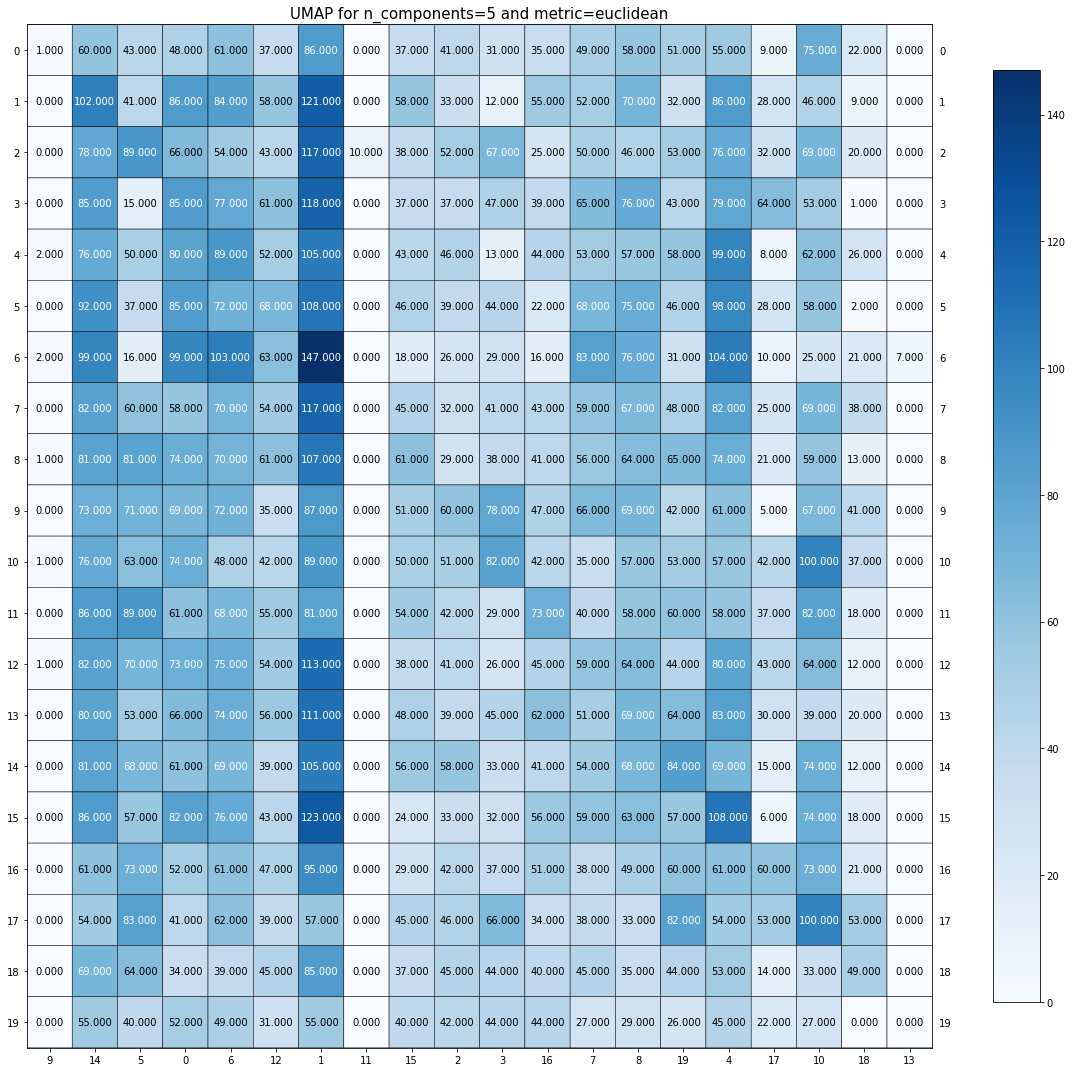

Homogeneity Score: 0.014609091532287627
Completeness: 0.015697714607844103
V-measure: 0.015133851352950665
Adjusted RI 0.002854246075200825
Adjusted MI 0.01186019186673016


In [32]:
umap_metrics(n_components=5, metric="euclidean", title="UMAP for n_components=5 and metric=euclidean")

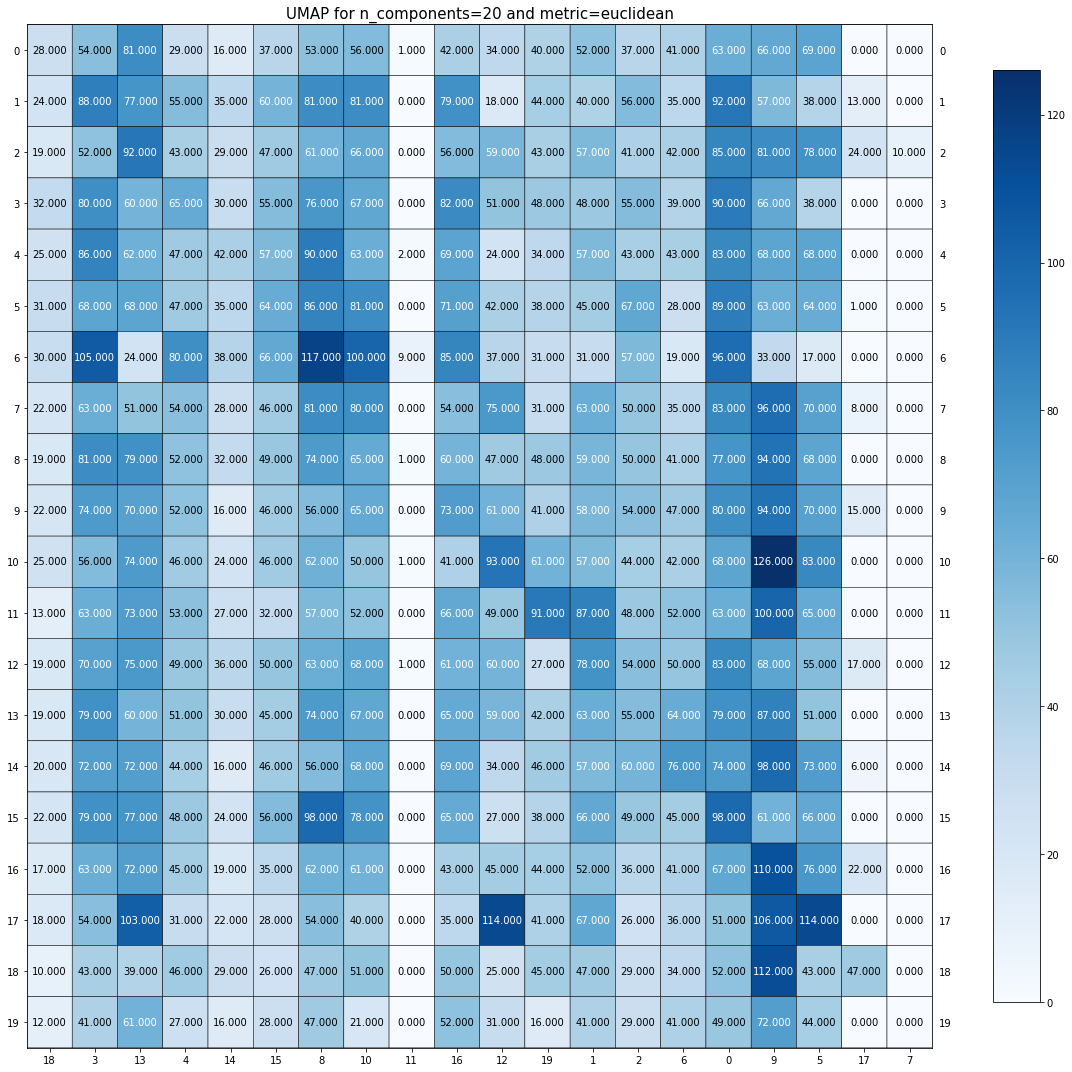

Homogeneity Score: 0.01438639461350556
Completeness: 0.015263170449296865
V-measure: 0.0148118188359035
Adjusted RI 0.002852245486350937
Adjusted MI 0.011509960261788143


In [33]:
umap_metrics(n_components=20, metric="euclidean", title="UMAP for n_components=20 and metric=euclidean")

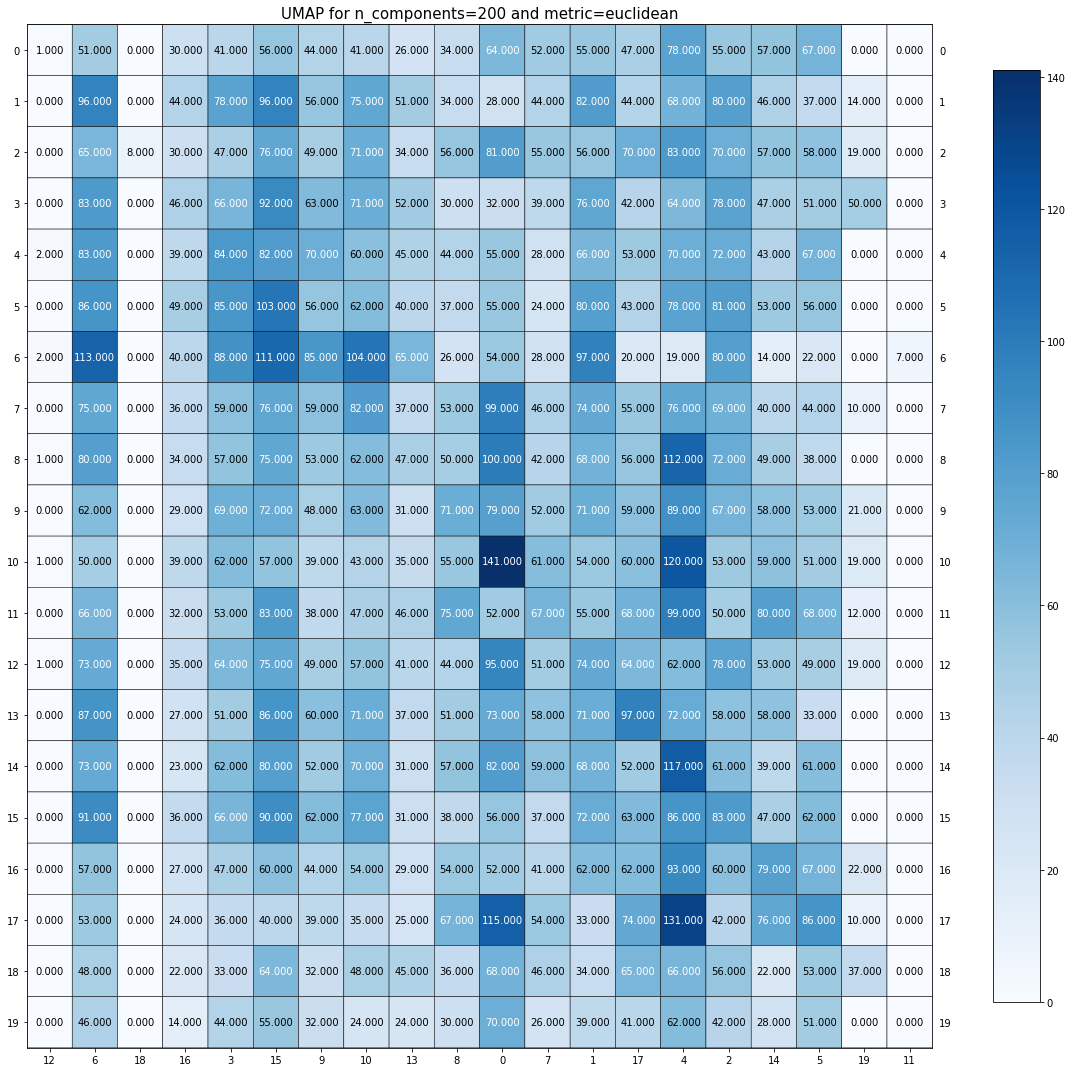

Homogeneity Score: 0.014994957245383243
Completeness: 0.016096460137258108
V-measure: 0.015526196737171455
Adjusted RI 0.0032262725677203517
Adjusted MI 0.0122662482636985


In [34]:
umap_metrics(n_components=200, metric="euclidean", title="UMAP for n_components=200 and metric=euclidean")

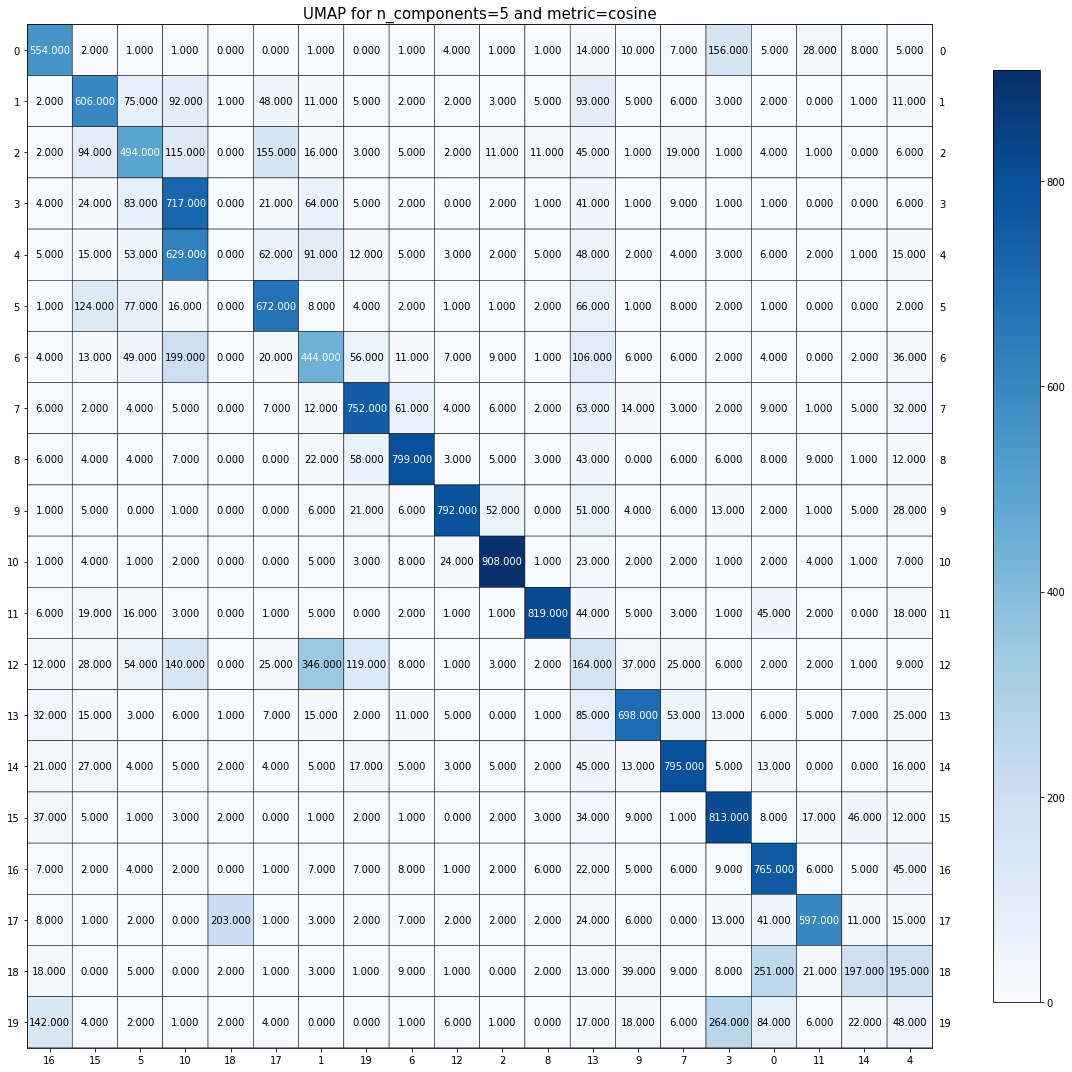

Homogeneity Score: 0.573063131404273
Completeness: 0.5864964429530796
V-measure: 0.5797019757996157
Adjusted RI 0.45613022764649963
Adjusted MI 0.5783286210097325


In [35]:
umap_metrics(n_components=5, metric="cosine", title="UMAP for n_components=5 and metric=cosine")

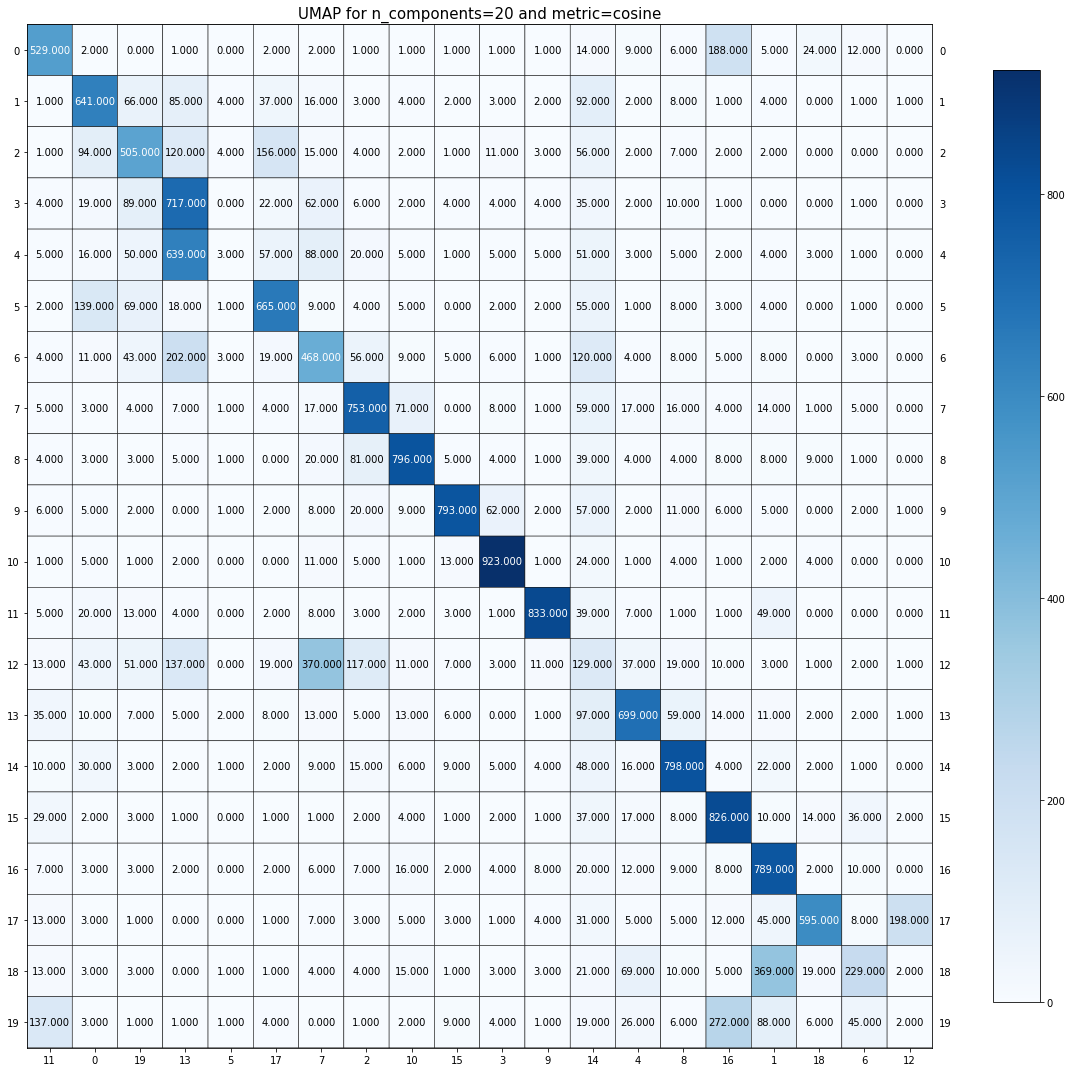

Homogeneity Score: 0.5722950878574007
Completeness: 0.5944802999251327
V-measure: 0.5831767777030937
Adjusted RI 0.4567080871600432
Adjusted MI 0.5817930960251217


In [36]:
umap_metrics(n_components=20, metric="cosine", title="UMAP for n_components=20 and metric=cosine")

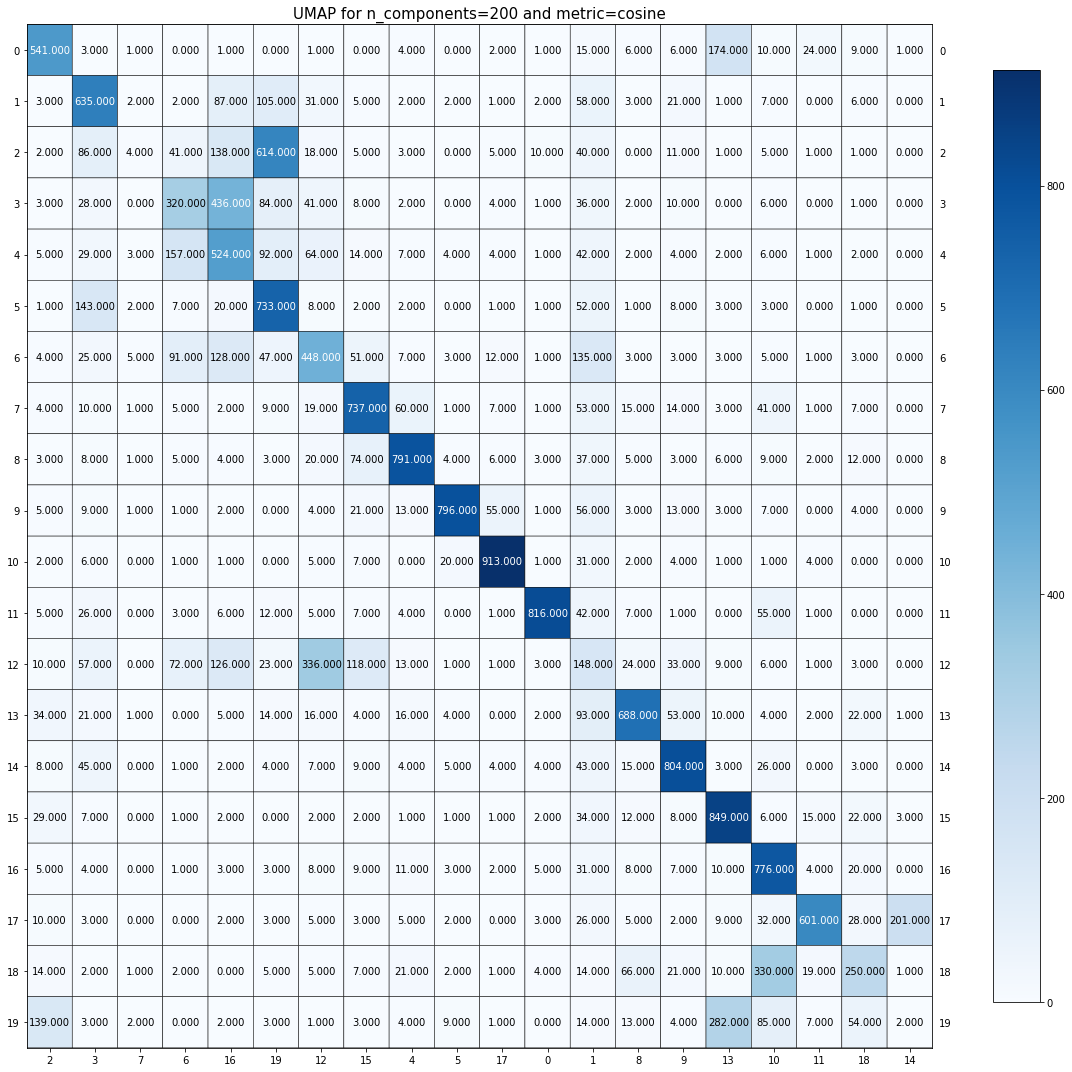

Homogeneity Score: 0.564586981277977
Completeness: 0.5858709972477733
V-measure: 0.5750321070888809
Adjusted RI 0.44453666969983924
Adjusted MI 0.573622118041904


In [37]:
umap_metrics(n_components=200, metric="cosine", title="UMAP for n_components=200 and metric=cosine")

### QUESTION 12: Analyze the contingency matrices. Which setting works best and why? What about for each metric choice?

The UMAP setting with **n_components = 200 and metric = cosine** works best in terms of the contingency matrix as well as the 5 evaluation measures compared to the rest of the combinations. This is because setting a higher number of components allows UMAP to better capture complex patterns within the data leading to better clustering. The Cosine similarity metric is better in comparison to Euclidean distance as it is ideal for high-dimensional/ sparse data where curse of dimensionality can affect the results. Euclidean is better equipped for data that exhibit linear relationships. 

In [38]:
for i in range(0,6):
  print(eval_scores['n_components'][i])
  print(eval_scores['metric'][i])
  print(eval_scores['h_score'][i])
  print(eval_scores['c_score'][i])
  print(eval_scores['v_score'][i])
  print(eval_scores['adj_rand'][i])
  print(eval_scores['adj_mutual_info'][i])

5
euclidean
0.014609091532287627
0.015697714607844103
0.015133851352950665
0.002854246075200825
0.01186019186673016
20
euclidean
0.01438639461350556
0.015263170449296865
0.0148118188359035
0.002852245486350937
0.011509960261788143
200
euclidean
0.014994957245383243
0.016096460137258108
0.015526196737171455
0.0032262725677203517
0.0122662482636985
5
cosine
0.573063131404273
0.5864964429530796
0.5797019757996157
0.45613022764649963
0.5783286210097325
20
cosine
0.5722950878574007
0.5944802999251327
0.5831767777030937
0.4567080871600432
0.5817930960251217
200
cosine
0.564586981277977
0.5858709972477733
0.5750321070888809
0.44453666969983924
0.573622118041904


### QUESTION 13: So far, we have attempted K-Means clustering with 4 different representation learning techniques (sparse TF-IDF representation, PCA-reduced, NMF-reduced, UMAP-reduced). Compare and contrast the clustering results across the 4 choices, and suggest an approach that is best for the K-Means clustering task on the 20-class text data. Choose any choice of clustering metrics for your comparison.

On comparing the 5 evaluation metrics for K-means clustering the UMAP reduced data with the setting n_components = 200 and metric = cosine gave the best results for K-means clustering among the 4 different representation learning techniques. 

### QUESTION 14: Use UMAP to reduce the dimensionality properly, and perform Agglomerative clustering with n_clusters=20 . Compare the performance of “ward” and “single” linkage criteria. Report the five clustering evaluation metrics for each case.

The Agglomerative performance of ward linkage was better than single linkage criteria on comparing the 5 clustering evaluation metrics. 

In [39]:
# Dimensionality Reduction using UMAP 
reducer20 = umap.UMAP(n_components=200, metric="cosine")
embedding20 = reducer20.fit_transform(X_train_tfidf20)

# Ground truth labels
ground_truth20 = newsgroups_data20.target

###  Agglomerative Clustering (Ward)

In [40]:
# Agglomerative Clustering for ward algorithm 

ward = AgglomerativeClustering(n_clusters = 20, affinity ="euclidean", linkage="ward")
ward.fit(embedding20)
ward_labels = ward.labels_ 

/Users/vaniagrawal/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [41]:
# 5 clustering Evaluation Metrics
h_score = homogeneity_score(ground_truth20, ward_labels)
c_score = completeness_score(ground_truth20,ward_labels) 
v_score = v_measure_score(ground_truth20,ward_labels)
adj_rand = adjusted_rand_score(ground_truth20, ward_labels)
adj_mutual_info = adjusted_mutual_info_score(ground_truth20, ward_labels)

# Prints 5 clustering Evaluation Metrics 
print("Homogeneity Score:", h_score)
print("Completeness:", c_score)
print("V-measure:", v_score)
print("Adjusted RI", adj_rand)
print("Adjusted MI", adj_mutual_info)

Homogeneity Score: 0.5657747385780165
Completeness: 0.5875369073722306
V-measure: 0.5764505046674958
Adjusted RI 0.43768097994417804
Adjusted MI 0.5750449287480054


###  Agglomerative Clustering (Single Linkage Criteria)

In [42]:
# Agglomerative Clustering for (Single Linkage Criteria) 

single = AgglomerativeClustering(n_clusters = 20, affinity ="euclidean", linkage="single")
single.fit(embedding20)
single_labels = single.labels_ 

/Users/vaniagrawal/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [43]:
# 5 clustering Evaluation Metrics
h_score = homogeneity_score(ground_truth20, single_labels)
c_score = completeness_score(ground_truth20,single_labels) 
v_score = v_measure_score(ground_truth20,single_labels)
adj_rand = adjusted_rand_score(ground_truth20, single_labels)
adj_mutual_info = adjusted_mutual_info_score(ground_truth20, single_labels)

# Prints 5 clustering Evaluation Metrics 
print("Homogeneity Score:", h_score)
print("Completeness:", c_score)
print("V-measure:", v_score)
print("Adjusted RI", adj_rand)
print("Adjusted MI", adj_mutual_info)

Homogeneity Score: 0.01695239351921457
Completeness: 0.36823784187459485
V-measure: 0.03241262228645149
Adjusted RI 0.00046796298443246403
Adjusted MI 0.02770166493579416


## Question 15: 

### 15.1 Apply HDBSCAN on UMAP-transformed 20-category data. Use min_cluster_size=100.

In [44]:
# Dimensionality Reduction using UMAP 
reducer20 = umap.UMAP(n_components=200, metric="cosine")
embedding20 = reducer20.fit_transform(X_train_tfidf20)

# Ground truth labels
ground_truth20 = newsgroups_data20.target

# HDBSCAN model
min_cluster_size = 100
hdbscan_mod = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size)
hdbscan_cluster = hdbscan_mod.fit_predict(embedding20)

In [45]:
# 5 clustering Evaluation Metrics
h_score = homogeneity_score(ground_truth20, hdbscan_cluster)
c_score = completeness_score(ground_truth20,hdbscan_cluster) 
v_score = v_measure_score(ground_truth20,hdbscan_cluster)
adj_rand = adjusted_rand_score(ground_truth20, hdbscan_cluster)
adj_mutual_info = adjusted_mutual_info_score(ground_truth20, hdbscan_cluster)

# Prints 5 clustering Evaluation Metrics 
print("Homogeneity Score:", h_score)
print("Completeness:", c_score)
print("V-measure:", v_score)
print("Adjusted RI", adj_rand)
print("Adjusted MI", adj_mutual_info)

Homogeneity Score: 0.4190806671652832
Completeness: 0.6166314252622905
V-measure: 0.49901572258039667
Adjusted RI 0.20196227347874798
Adjusted MI 0.4977949782155543


### 15.2 Vary the min cluster size among 20, 100, 200 and report your findings in terms of the five clustering evaluation metrics - you will plot the best contingency matrix in the next question. Feel free to try modifying other parameters in HDBSCAN to get better performance.

In [46]:
min_cluster_sizes = [20, 100, 200]

for cluster_size in min_cluster_sizes:
    # Dimensionality Reduction using UMAP 
    reducer20 = umap.UMAP(n_components=200, metric="cosine")
    embedding20 = reducer20.fit_transform(X_train_tfidf20)

    # Ground truth labels
    ground_truth20 = newsgroups_data20.target

    # HDBSCAN model
    hdbscan_mod = hdbscan.HDBSCAN(min_cluster_size = cluster_size)
    hdbscan_cluster = hdbscan_mod.fit_predict(embedding20)

    # 5 clustering Evaluation Metrics
    h_score = homogeneity_score(ground_truth20, hdbscan_cluster)
    c_score = completeness_score(ground_truth20,hdbscan_cluster) 
    v_score = v_measure_score(ground_truth20,hdbscan_cluster)
    adj_rand = adjusted_rand_score(ground_truth20, hdbscan_cluster)
    adj_mutual_info = adjusted_mutual_info_score(ground_truth20, hdbscan_cluster)

    # Prints 5 clustering Evaluation Metrics for each min_cluster_size
    print("-"*20 + f" HDBSCAN clustering with min_cluster_size={cluster_size} " + "-"*20)
    print("Homogeneity Score:", h_score)
    print("Completeness:", c_score)
    print("V-measure:", v_score)
    print("Adjusted RI", adj_rand)
    print("Adjusted MI", adj_mutual_info)

-------------------- HDBSCAN clustering with min_cluster_size=20 --------------------
Homogeneity Score: 0.4162914667318007
Completeness: 0.43305407272219654
V-measure: 0.4245073570966044
Adjusted RI 0.06390645681972563
Adjusted MI 0.41092792978375625
-------------------- HDBSCAN clustering with min_cluster_size=100 --------------------
Homogeneity Score: 0.42267329012263655
Completeness: 0.6179261319474856
V-measure: 0.5019815804306648
Adjusted RI 0.22145540038735279
Adjusted MI 0.5009773908638369
-------------------- HDBSCAN clustering with min_cluster_size=200 --------------------
Homogeneity Score: 0.4110517095808222
Completeness: 0.6042128469358168
V-measure: 0.4892571538905934
Adjusted RI 0.20558464620370817
Adjusted MI 0.48822498303646295


## Question 16

### 16.1 Plot the contingency matrix for the best clustering model from Question 15.

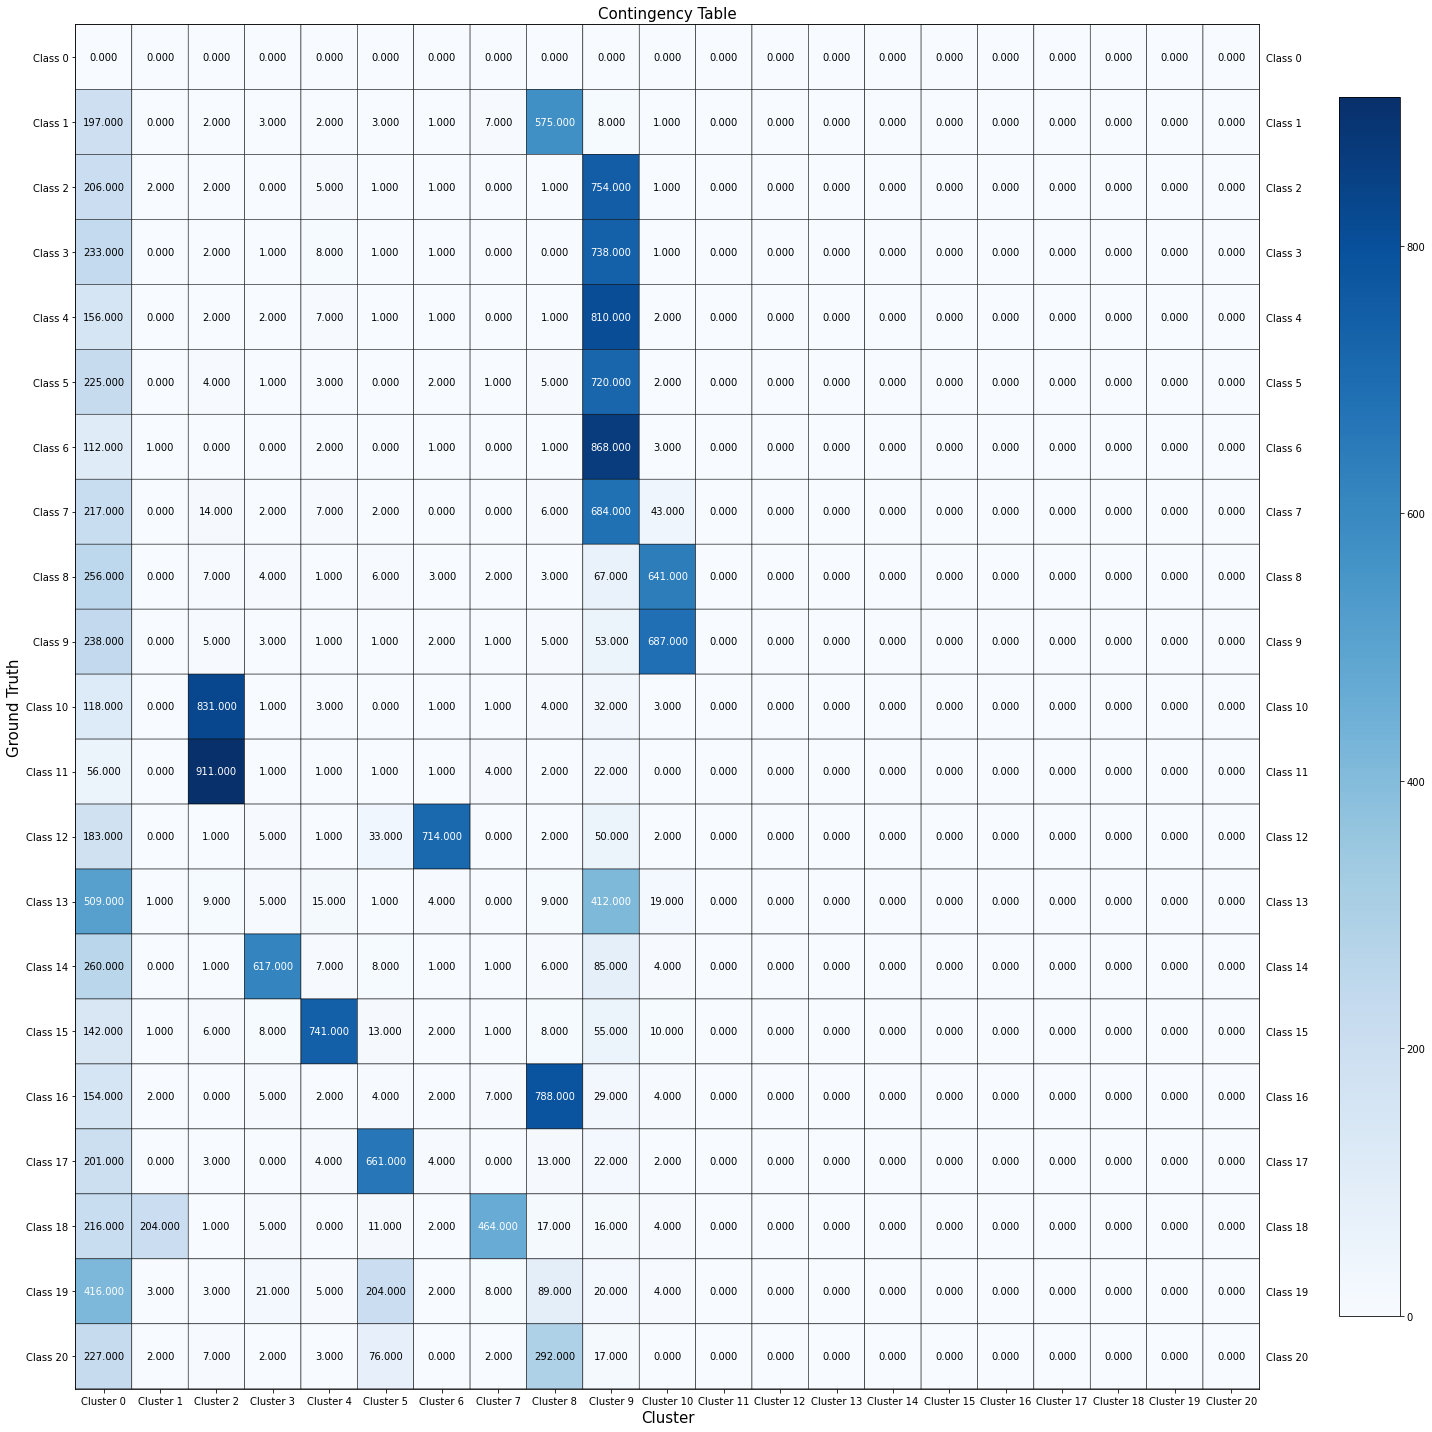

In [48]:
# Ground truth labels
ground_truth20 = newsgroups_data20.target

# Best HDBSCAN model
best_min_cluster_size = 100
best_hdbscan_mod = hdbscan.HDBSCAN(min_cluster_size = best_min_cluster_size)
best_hdbscan_cluster = hdbscan_mod.fit_predict(embedding20)

mat_hdbscan20 = confusion_matrix(ground_truth20, best_hdbscan_cluster)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,21)]
ylabels = [f'Class {i}'.format(i) for i in range(0,21)]
plotmat.plot_mat(mat_hdbscan20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

### 16.2 How many clusters are given by the model? What does “-1” mean for the clustering labels? Interpret the contingency matrix considering the answer to these questions.

# Part 2 - Deep Learning and Clustering of Image Data

## Question 19

### 19.1 In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?